In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

## Prepare Data set

In [2]:
Data_Base_Path = './datas/UCR_TS_Archive_2015'

In [3]:
import os
flist = [x for x in os.listdir(Data_Base_Path) if os.path.isdir(os.path.join(Data_Base_Path, x))]
flist.sort(key=str.lower)
for index, name in enumerate(flist):
    print("%d: %s"%(index, name))

0: 50words
1: Adiac
2: ArrowHead
3: Beef
4: BeetleFly
5: BirdChicken
6: Car
7: CBF
8: ChlorineConcentration
9: CinC_ECG_torso
10: Coffee
11: Computers
12: Cricket_X
13: Cricket_Y
14: Cricket_Z
15: DiatomSizeReduction
16: DistalPhalanxOutlineAgeGroup
17: DistalPhalanxOutlineCorrect
18: DistalPhalanxTW
19: Earthquakes
20: ECG200
21: ECG5000
22: ECGFiveDays
23: ElectricDevices
24: FaceAll
25: FaceFour
26: FacesUCR
27: FISH
28: FordA
29: FordB
30: Gun_Point
31: Ham
32: HandOutlines
33: Haptics
34: Herring
35: InlineSkate
36: InsectWingbeatSound
37: ItalyPowerDemand
38: LargeKitchenAppliances
39: Lighting2
40: Lighting7
41: MALLAT
42: Meat
43: MedicalImages
44: MiddlePhalanxOutlineAgeGroup
45: MiddlePhalanxOutlineCorrect
46: MiddlePhalanxTW
47: MoteStrain
48: NonInvasiveFatalECG_Thorax1
49: NonInvasiveFatalECG_Thorax2
50: OliveOil
51: OSULeaf
52: PhalangesOutlinesCorrect
53: Phoneme
54: Plane
55: ProximalPhalanxOutlineAgeGroup
56: ProximalPhalanxOutlineCorrect
57: ProximalPhalanxTW
58: Refr

In [4]:
dataset_index = 22
dataset_name = flist[dataset_index]
print(dataset_name)

ECGFiveDays


In [5]:
epsilon = 1e-8

In [6]:
def readData(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [7]:
X_train, Y_train = readData('%s/%s/%s_TRAIN'%(Data_Base_Path, dataset_name, dataset_name))
X_test, Y_test = readData('%s/%s/%s_TEST'%(Data_Base_Path, dataset_name, dataset_name))
series_length = X_train.shape[1]
nb_classes = len(np.unique(Y_train))
N_train = X_train.shape[0]
N_test = X_test.shape[0]
Y_train = (Y_train - Y_train.min()) / (Y_train.max() - Y_train.min()) * (nb_classes - 1)
Y_test = (Y_test - Y_test.min()) / (Y_test.max() - Y_test.min()) * (nb_classes - 1)

# ## Normalization
# X_train_mean = X_train.mean()
# X_train_std = X_train.std()
# X_train = (X_train - X_train.mean()) / (X_train.std() + epsilon)
# X_test = (X_test - X_test.mean()) / (X_test.std() + epsilon)

In [8]:
X_train = ((X_train.transpose() - X_train.mean()) / (X_train.std() + epsilon)).transpose()
X_test = ((X_test.transpose() - X_test.mean()) / (X_test.std() + epsilon)).transpose()

In [9]:
print('''Series length: %d
Classes number: %d
Train set Number: %d
Test set Number: %d'''%(series_length, nb_classes, N_train, N_test))

Series length: 136
Classes number: 2
Train set Number: 23
Test set Number: 861


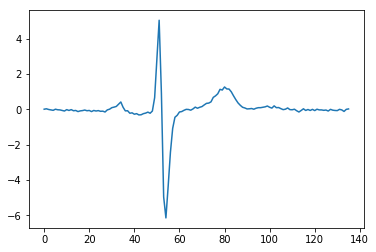

In [10]:
plt.plot(X_train[0,:])

## MFD Layers

In [11]:
import keras
from keras.engine.topology import Layer
import tensorflow as tf

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [12]:
class MRFFT(Layer):
    def compute_output_shape(self,input_shape):
        o_shape=[input_shape]*2
        return o_shape
    def call(self,inputs):
        t=tf.unstack(inputs,axis=2)
        ft=[tf.expand_dims(tf.spectral.rfft(k),-1) for k in t]
        ft=tf.concat(ft,-1)
        ift=tf.imag(ft)
        return [rft,ift]
class MIRFFT(Layer):
    def compute_output_shape(self,input_shape):
        return input_shape[0]
    def call(self,inputs):
        rft=inputs[0]
        ift=inputs[1]
        ft=tf.complex(rft,ift)
        t=tf.unstack(ft,axis=2)
        tt=[tf.expand_dims(tf.spectral.irfft(k),-1) for k in t]
        tt=tf.concat(tt,-1)
        return tt
class MFD_FFT(Layer):
    def __init__(self,in_shape,num_p,**kwargs):
        self.num_p = num_p
        self.in_shape=in_shape
        super(MFD_FFT,self).__init__(**kwargs)
        
    def compute_output_shape(self,input_shape):
        o_shape=input_shape[:2]+(self.num_p,input_shape[-1],)
        return o_shape
    
    def call(self,inputs):
        t=tf.unstack(inputs,axis=2)
        ft=[tf.expand_dims(tf.spectral.rfft(k),-1) for k in t]
        ft=tf.concat(ft,-1)
        fshape=self.in_shape
        
        m=fshape%self.num_p
        if m!=0:
            d=fshape//(self.num_p-1)
            _m=fshape%(self.num_p-1)
            if _m==0:
                _d=fshape//self.num_p-1
                _m1=fshape-_d*(self.num_p-1)
        else:
            d=fshape//self.num_p
        if m!=0:
            if _m==0:
                sp=tf.split(ft,[_d for _ in range(self.num_p-1)]+[_m1,],axis=1)
            else:
                sp=tf.split(ft,[d for _ in range(self.num_p-1)]+[_m,],axis=1)
        else:
            sp=tf.split(ft,[d for _ in range(self.num_p)],axis=1)
            
        at=None
        for i in range(self.num_p):
            t=None
            for k in range(self.num_p):
                if i!=k:
                    tp=sp[k]*0.
                else:
                    tp=sp[k]*1.
                if t is None:
                    t=tp
                else:
                    t=tf.concat([t,tp],1)
                    
            s=t
            ts=tf.unstack(s,axis=2)
            ts=[tf.expand_dims(tf.spectral.irfft(k),-1) for k in ts]
            s=tf.concat(ts,-1)
            if at is None:
                at=tf.expand_dims(s,2)
            else:
                at=tf.concat([at,tf.expand_dims(s,2)],2)
        return at

## Build Network Model

In [13]:
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Input, Activation, GlobalAveragePooling2D
from keras.layers import Dense,Conv1D, Conv2D, BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import logging

In [14]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
Y_train = to_categorical(Y_train, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)

In [15]:
## model
input_x = Input(shape = (series_length, 1))
y = Conv1D(64, kernel_size=8, padding='same', kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(input_x)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = MFD_FFT(in_shape=series_length//2+1, num_p=6)(y)
y = BatchNormalization()(y)
y = Conv2D(128, kernel_size=(5,1), padding='same', kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(256, kernel_size=(3,6), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = GlobalAveragePooling2D()(y)
output_y = Dense(nb_classes, activation='softmax', 
                 kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)

model = Model(input_x, output_y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 136, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 136, 64)           576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 136, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 136, 64)           0         
_________________________________________________________________
mfd_fft_1 (MFD_FFT)          (None, 136, 6, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 136, 6, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 6, 128)       41088     
__________

In [16]:
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(message)s',
                   datefmt='%Y-%m-%d %H:%M:%S',
                   filename='./logs/log-%s.log'%dataset_name,
                   filemode='w')

In [17]:
def MPCE(y_true,y_pred):
    C={}
    for k in y_true:
        if k in C.keys():
            C[k]+=1
        else:
            C[k]=1
    loss=0
    for i in range(len(y_true)):
        if y_true[i]!=y_pred[i]:
            loss+=(1/C[y_true[i]])
    loss/=nb_classes
    return loss

In [18]:
class MPCECallback(Callback):
    def on_epoch_end(self,epoch,logs=None):
        y_pred=np.argmax(self.model.predict(X_test),axis=1)
        y_t=np.argmax(Y_test,axis=1)
        l=MPCE(y_t,y_pred)
        logs['MPCE']=l
class HistoryLogger(Callback):
    def on_train_begin(self,logs=None):
        logging.warning('Begin Training............')
        self.best_acc=0.0
        self.best_mpce=1.0
    def on_epoch_end(self,epoch,logs=None):
        loss=logs['loss']
        acc=logs['acc']*100
        val_loss=logs['val_loss']
        val_acc=logs['val_acc']*100
        mpce=logs['MPCE']
        if val_acc>=self.best_acc:
            self.best_acc=val_acc
        if mpce<=self.best_mpce:
            self.best_mpce=mpce
        logging.info('%4d - over - loss: %.4f, acc: %.2f | val_loss: %.4f, val_acc: %.2f, MPCE:%.4f | best_acc: %.2f, best_mpce:%.4f'%(epoch,loss,acc,val_loss,val_acc,mpce,self.best_acc,self.best_mpce))
    def on_train_end(self,logs=None):
        logging.warning('End Training............')

In [19]:
model_checkpoint = ModelCheckpoint('./weights/%s_weights.h5' % dataset_name, 
                                   verbose=1, monitor='val_acc', save_best_only=True, 
                                   save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=30, mode='auto', 
                              factor=1.0/np.cbrt(2), cooldown=0, min_lr=1e-5, verbose=1)
callback_list = [model_checkpoint, reduce_lr, MPCECallback(), HistoryLogger()]

## Train

In [20]:
## 设置小的epochs，每次可以加载上次的模型参数，接着训练，便于控制和输出
epochs = 1200
batch_size = 20
learning_rate = 1e-3

In [21]:
optim = Adam(lr=learning_rate)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, callbacks=callback_list, 
                 verbose=1, validation_data=(X_test, Y_test))

Train on 23 samples, validate on 861 samples
Epoch 1/1200
23/23 [==============================] - 21s 915ms/step - loss: 1.5492 - acc: 0.6087 - val_loss: 1.5438 - val_acc: 0.4971
Epoch 2/1200
23/23 [==============================] - 13s 549ms/step - loss: 1.4013 - acc: 0.7391 - val_loss: 1.5145 - val_acc: 0.5714
Epoch 3/1200
23/23 [==============================] - 12s 543ms/step - loss: 1.3151 - acc: 0.7826 - val_loss: 1.4855 - val_acc: 0.6446
Epoch 4/1200
23/23 [==============================] - 13s 545ms/step - loss: 1.2681 - acc: 0.8696 - val_loss: 1.4692 - val_acc: 0.5645
Epoch 5/1200
23/23 [==============================] - 13s 549ms/step - loss: 1.2480 - acc: 0.8261 - val_loss: 1.4484 - val_acc: 0.5517
Epoch 6/1200
23/23 [==============================] - 13s 545ms/step - loss: 1.1909 - acc: 0.8261 - val_loss: 1.4391 - val_acc: 0.5134
Epoch 7/1200
23/23 [==============================] - 13s 548ms/step - loss: 1.0915 - acc: 0.9130 - val_loss: 1.4307 - val_acc: 0.5029
Epoch 8/12

23/23 [==============================] - 13s 548ms/step - loss: 0.6122 - acc: 1.0000 - val_loss: 0.9394 - val_acc: 0.9756
Epoch 32/1200
23/23 [==============================] - 13s 546ms/step - loss: 0.5910 - acc: 1.0000 - val_loss: 0.9313 - val_acc: 0.9965
Epoch 33/1200
23/23 [==============================] - 13s 546ms/step - loss: 0.5561 - acc: 1.0000 - val_loss: 0.9291 - val_acc: 0.9977
Epoch 34/1200
23/23 [==============================] - 13s 546ms/step - loss: 0.5543 - acc: 1.0000 - val_loss: 0.9313 - val_acc: 0.9803
Epoch 35/1200
23/23 [==============================] - 13s 547ms/step - loss: 0.5478 - acc: 1.0000 - val_loss: 0.9325 - val_acc: 0.9559
Epoch 36/1200
23/23 [==============================] - 13s 546ms/step - loss: 0.5702 - acc: 1.0000 - val_loss: 0.9252 - val_acc: 0.9326
Epoch 37/1200
23/23 [==============================] - 13s 546ms/step - loss: 0.5348 - acc: 1.0000 - val_loss: 0.9100 - val_acc: 0.9326
Epoch 38/1200
23/23 [==============================] - 13s 547

23/23 [==============================] - 13s 545ms/step - loss: 0.4333 - acc: 1.0000 - val_loss: 0.6663 - val_acc: 1.0000
Epoch 64/1200
23/23 [==============================] - 12s 542ms/step - loss: 0.4352 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.9942
Epoch 65/1200
23/23 [==============================] - 12s 543ms/step - loss: 0.4233 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.9675
Epoch 66/1200
23/23 [==============================] - 12s 543ms/step - loss: 0.4190 - acc: 1.0000 - val_loss: 0.7248 - val_acc: 0.9036
Epoch 67/1200
23/23 [==============================] - 13s 544ms/step - loss: 0.4233 - acc: 1.0000 - val_loss: 0.7416 - val_acc: 0.8734
Epoch 68/1200
23/23 [==============================] - 12s 541ms/step - loss: 0.4363 - acc: 1.0000 - val_loss: 0.7449 - val_acc: 0.8676
Epoch 69/1200
23/23 [==============================] - 13s 545ms/step - loss: 0.4085 - acc: 1.0000 - val_loss: 0.7361 - val_acc: 0.8792
Epoch 70/1200
23/23 [==============================] - 13s 544

23/23 [==============================] - 13s 544ms/step - loss: 0.3768 - acc: 1.0000 - val_loss: 0.6217 - val_acc: 0.8990
Epoch 97/1200
23/23 [==============================] - 13s 546ms/step - loss: 0.3772 - acc: 1.0000 - val_loss: 0.5834 - val_acc: 0.9222
Epoch 98/1200
23/23 [==============================] - 12s 543ms/step - loss: 0.3775 - acc: 1.0000 - val_loss: 0.5669 - val_acc: 0.9257
Epoch 99/1200
23/23 [==============================] - 13s 544ms/step - loss: 0.3909 - acc: 1.0000 - val_loss: 0.5696 - val_acc: 0.9233
Epoch 100/1200
23/23 [==============================] - 13s 546ms/step - loss: 0.3727 - acc: 1.0000 - val_loss: 0.5827 - val_acc: 0.9175
Epoch 101/1200
23/23 [==============================] - 12s 543ms/step - loss: 0.3915 - acc: 1.0000 - val_loss: 0.6230 - val_acc: 0.8931
Epoch 102/1200
23/23 [==============================] - 13s 545ms/step - loss: 0.3680 - acc: 1.0000 - val_loss: 0.6766 - val_acc: 0.8513
Epoch 103/1200
23/23 [==============================] - 13s

KeyboardInterrupt: 

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['MPCE'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc: %.4f'%max(hist.history['acc']),'MPCE: %.4f'%min(hist.history['MPCE']),'val_acc: %.4f'%max(hist.history['val_acc'])])
plt.title('Training process: %s' % dataset_name)
plt.savefig('./figures/Training process_%s.png' % dataset_name, dpi=300)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss: %.4f'%min(hist.history['loss']),'val_loss: %.4f'%min(hist.history['val_loss'])])
plt.title('Loss curve: %s' % dataset_name)
plt.savefig('./figures/Loss curve_%s.png' % dataset_name, dpi=300)

## CAM

In [23]:
from keras import backend as K

In [24]:
def calculate_CAM(cam_func, cam_sample, series_length):
    cam_output = cam_func([cam_sample, 1.])
    cam_matrix  = np.zeros((series_length, nb_classes), dtype=np.float32)
    for i in range(0, cam_output[0].shape[1]):
        for j in range(class_weights.shape[1]):
            cam_matrix[i+1, j] = np.dot(cam_output[0][0, i, 0, :], class_weights[:, j])
    cam_matrix = cam_matrix - cam_matrix.min(axis=0)
    cam_matrix = cam_matrix / (cam_matrix.max(axis=0) - cam_matrix.min(axis=0))
    return cam_matrix

In [25]:
model.load_weights('./weights/%s_weights.h5' % dataset_name)

In [26]:
model.layers

In [27]:
class_weights = model.layers[-1].get_weights()[0]
last_conv_acti = model.layers[-3]
cam_input = model.input

In [28]:
cam_func = K.function([cam_input, K.learning_phase()], [last_conv_acti.output])

In [42]:
CAM_INDEX = 1
cam_sample = X_train[CAM_INDEX][np.newaxis, ...]
cam_sample_Y = np.where(Y_train[CAM_INDEX]==1)[0][0]
cam_sample_Y
cam_matrix = calculate_CAM(cam_func, cam_sample, series_length)

In [43]:
CAM_INDEX_1 = 3
cam_sample_1 = X_train[CAM_INDEX_1][np.newaxis, ...]
cam_sample_Y_1 = np.where(Y_train[CAM_INDEX_1]==1)[0][0]
cam_sample_Y_1
cam_matrix_1 = calculate_CAM(cam_func, cam_sample_1, series_length)

In [44]:
import pandas as pd

In [45]:
sequence_df = pd.DataFrame(cam_sample[0,:,0],
                           index=range(cam_sample.shape[1]),
                           columns=range(1))
cam_df = pd.DataFrame(cam_matrix, 
                      index=range(cam_matrix.shape[0]),
                      columns=range(cam_matrix.shape[1]))

In [46]:
sequence_df_1 = pd.DataFrame(cam_sample_1[0,:,0],
                           index=range(cam_sample_1.shape[1]),
                           columns=range(1))
cam_df_1 = pd.DataFrame(cam_matrix_1, 
                      index=range(cam_matrix_1.shape[0]),
                      columns=range(cam_matrix_1.shape[1]))

Text(0.5,0.98,'CAM: Data set: ECGFiveDays')

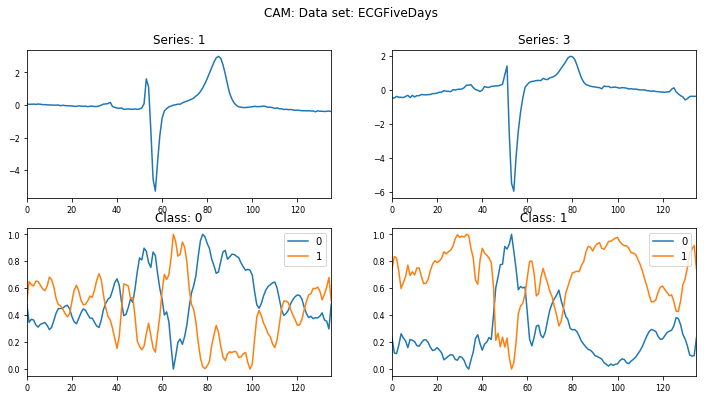

In [51]:
fig, axs = plt.subplots(2, 2, squeeze=False, figsize=(12, 6))
sequence_df.plot(subplots=False, legend=None, ax=axs[0][0], fontsize=8, title='Series: %d' % CAM_INDEX)
cam_df.plot(subplots=False, ax=axs[1][0], fontsize=8, title='Class: %d' % cam_sample_Y)
sequence_df_1.plot(subplots=False, legend=None, ax=axs[0][1], fontsize=8, title='Series: %d' % CAM_INDEX_1)
cam_df_1.plot(subplots=False, ax=axs[1][1], fontsize=8, title='Class: %d' % cam_sample_Y_1)
fig.suptitle('CAM: Data set: %s' % dataset_name)

In [54]:
fig.savefig('./figures/CAM_%s.png' % dataset_name, dpi=300)